In [61]:
%reset

In [131]:
import numpy as np
from numpy import polyfit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from scipy.stats import linregress
from math import floor, sqrt, pi
from pathlib import Path
import json
from matplotlib.backends.backend_pdf import PdfPages
from uncertainties import ufloat
import uncertainties.unumpy as unp
from glob import glob
import os
import re

import warnings
warnings.filterwarnings("error")


_plot_params = 0
def plot_init( numrows, numcols, axis = True ):
    plt.figure( figsize = ( numcols * 6, numrows * 4  ) )
    global _plot_params
    _plot_params = [ numrows, numcols, 0 ]
    if( axis ):
        plot_next()
def plot_next():
    _plot_params[2] += 1
    plt.subplot( *_plot_params )
def plot_goto( i_row, i_col ):
    _plot_params[2] = i_row * _plot_params[1] + i_col + 1
    plt.subplot( *_plot_params )

In [63]:
# Data saving path
savepath = "A06_results"

## Important routine to summarize all results in a single datafile

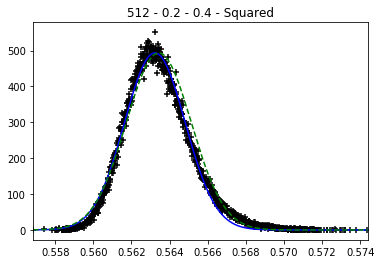

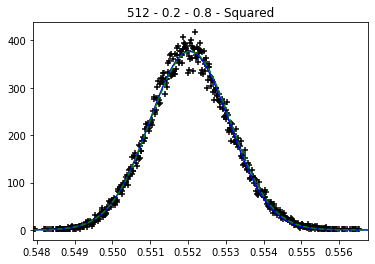

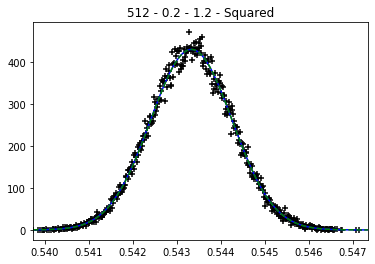

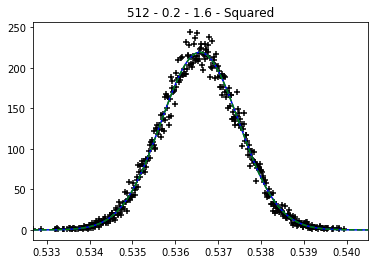

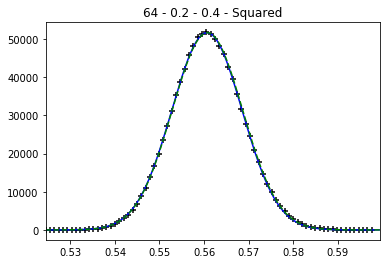

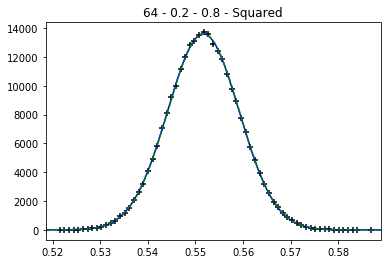

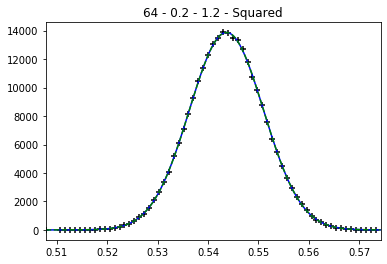

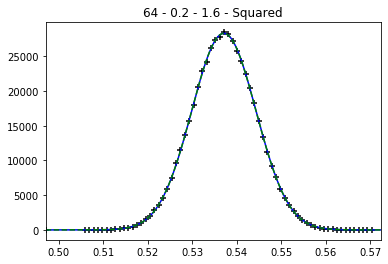

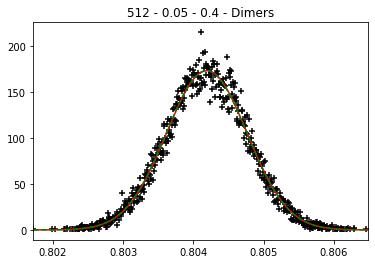

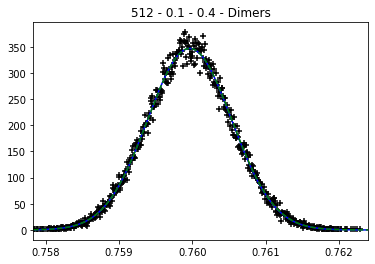

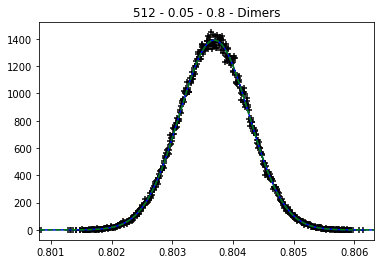

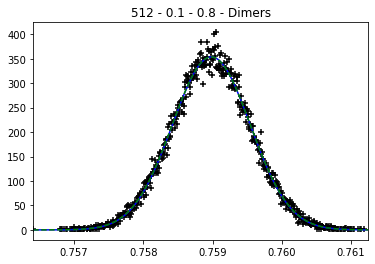

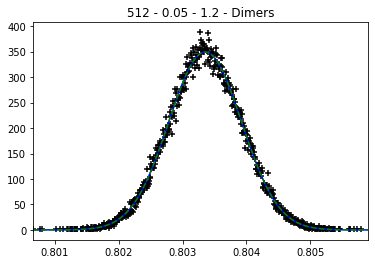

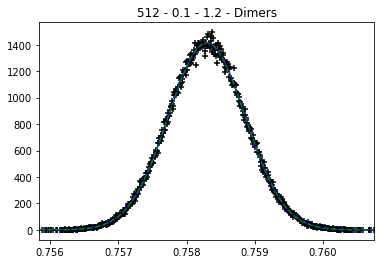

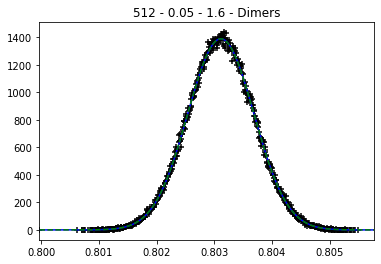

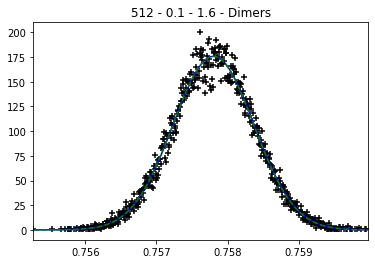

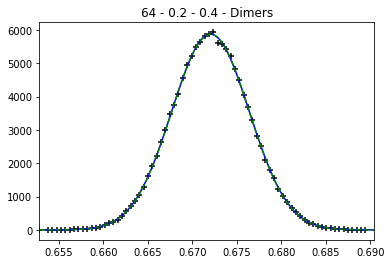

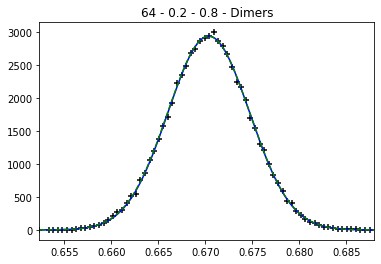

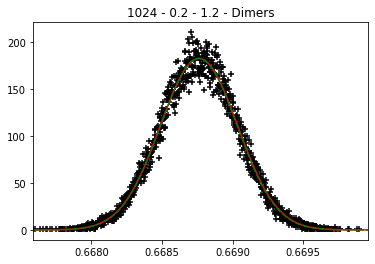

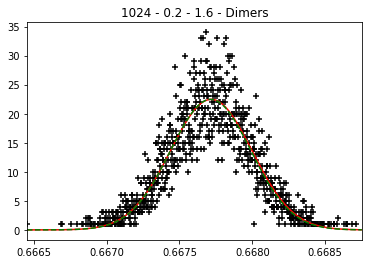

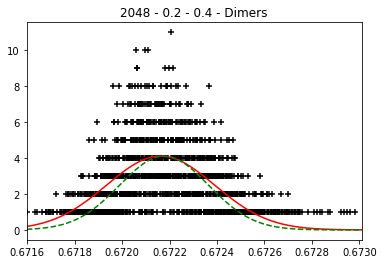

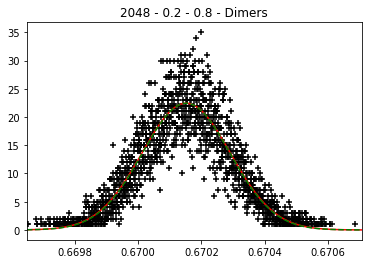

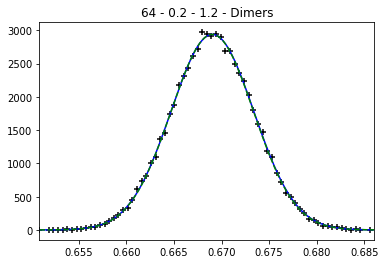

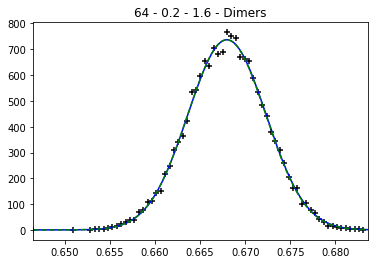

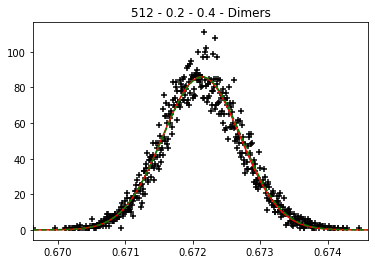

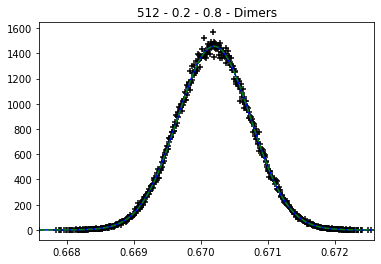

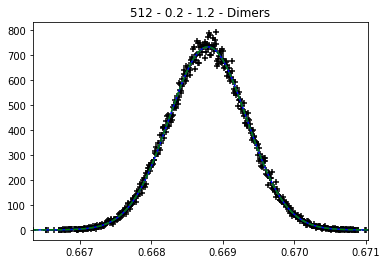

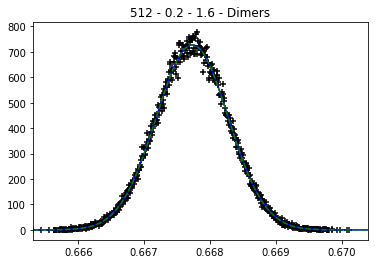

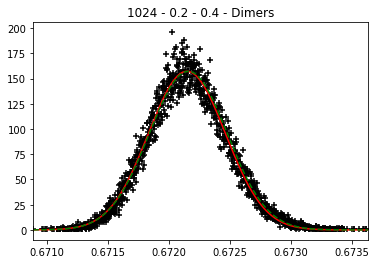

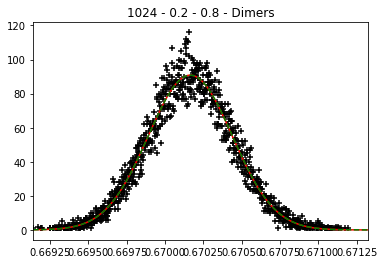

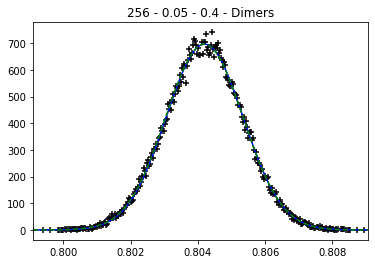

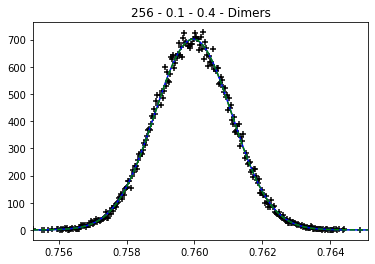

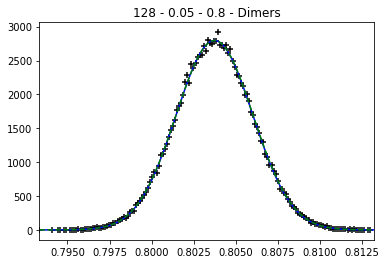

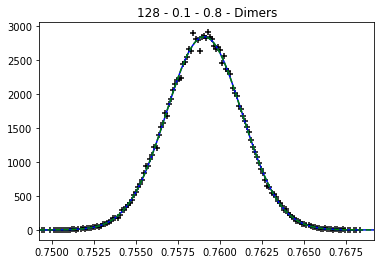

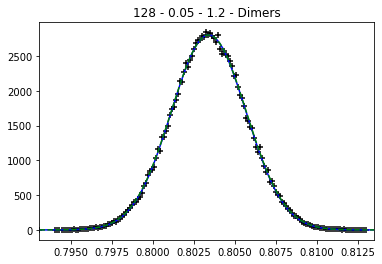

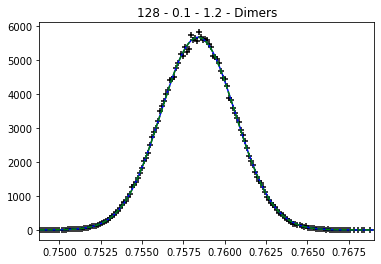

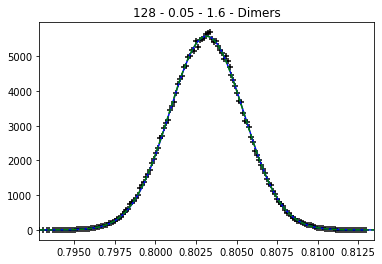

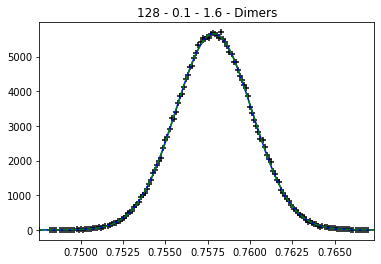

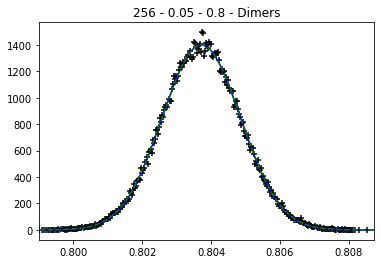

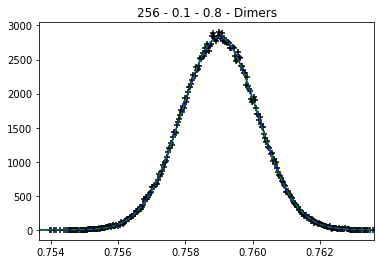

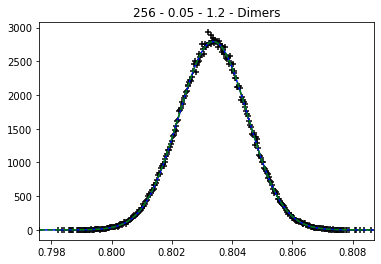

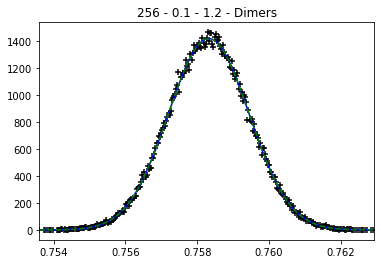

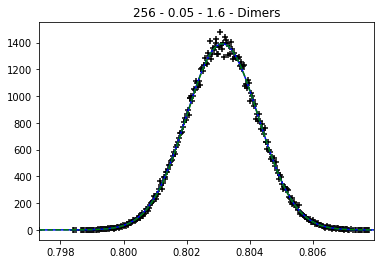

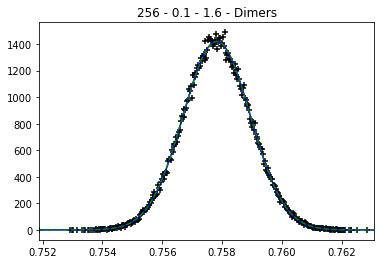

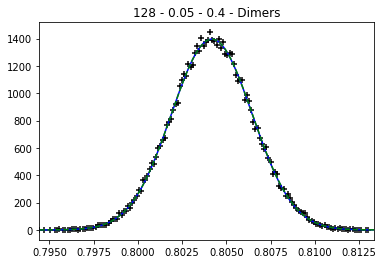

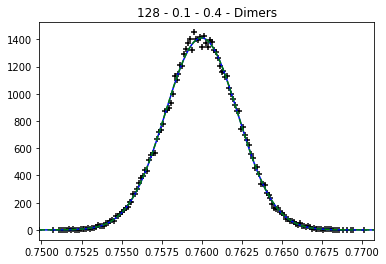

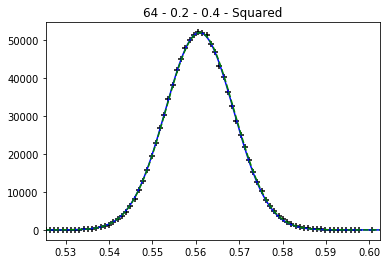

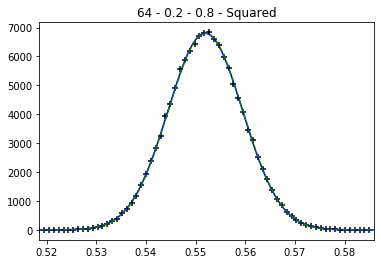

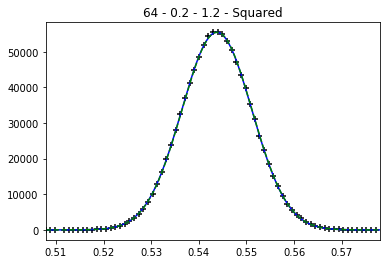

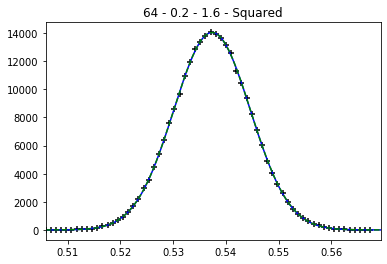

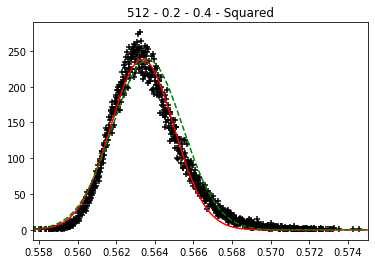

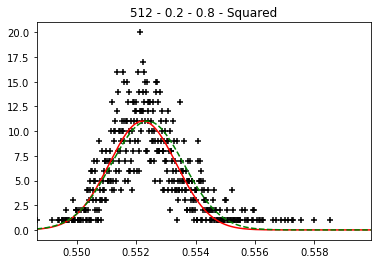

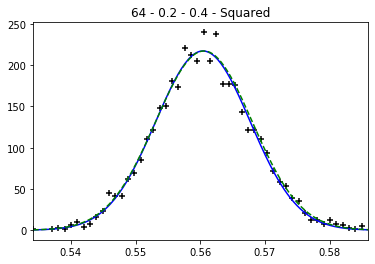

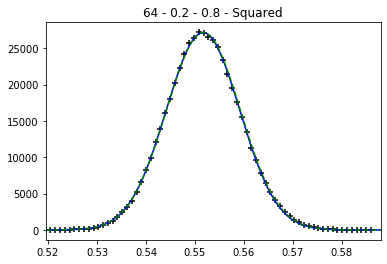

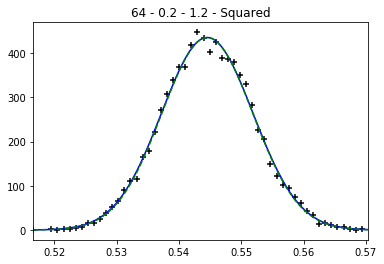

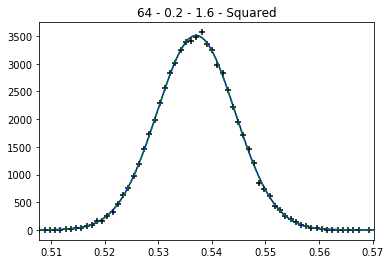

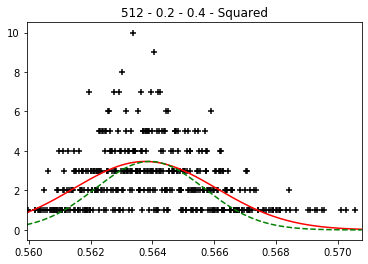

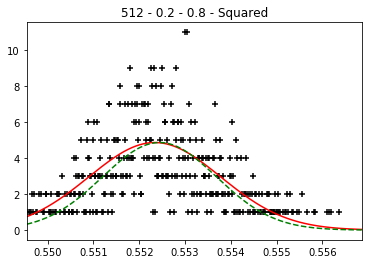

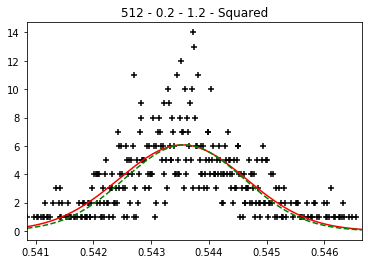

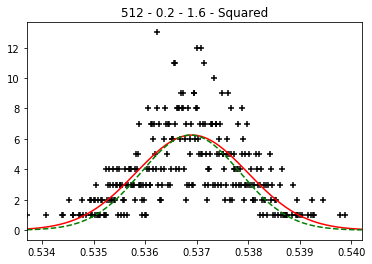

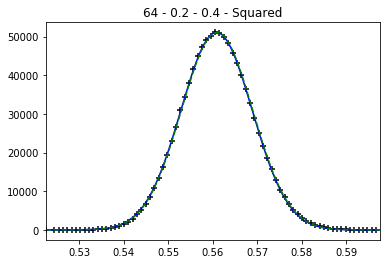

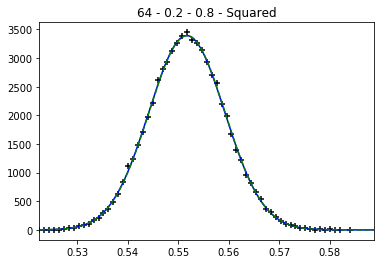

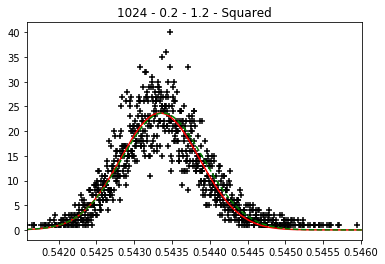

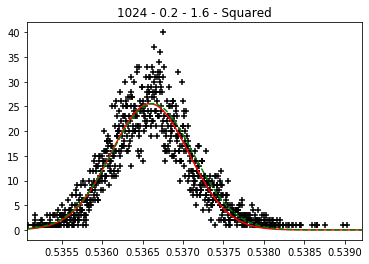

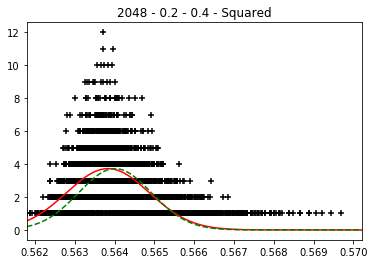

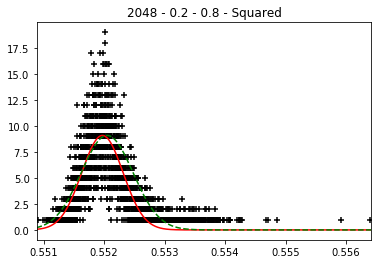

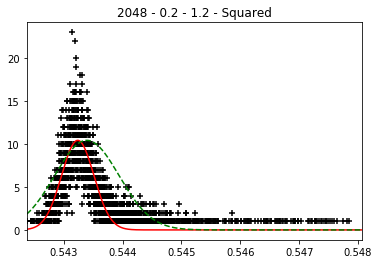

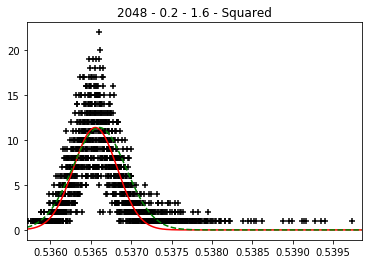

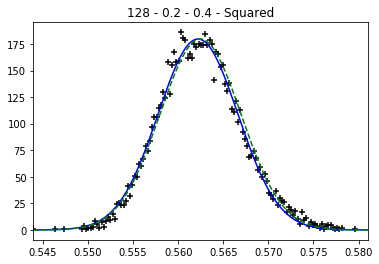

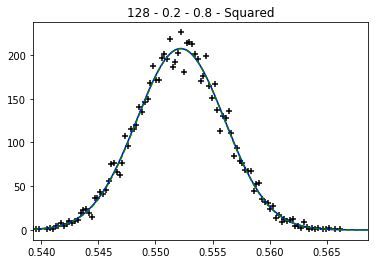

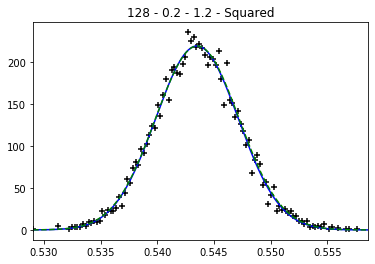

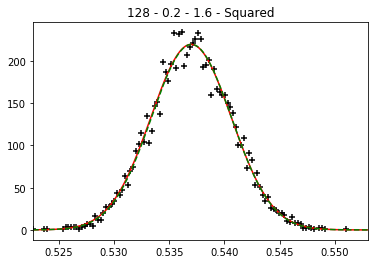

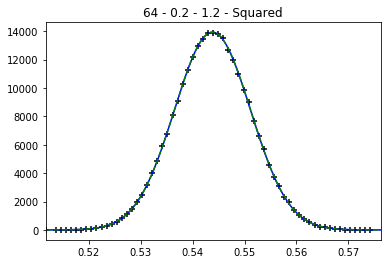

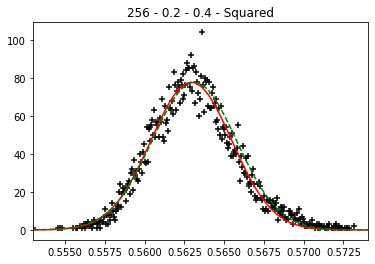

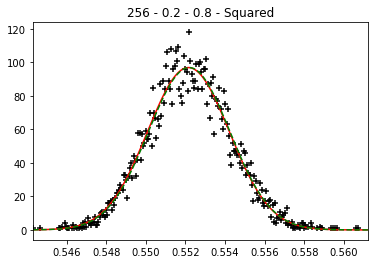

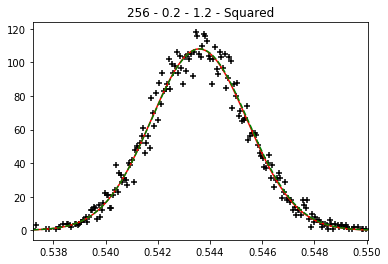

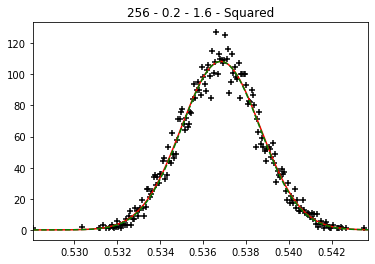

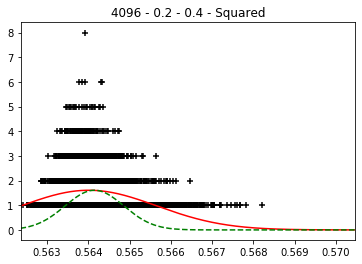

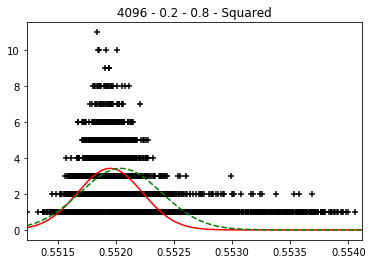

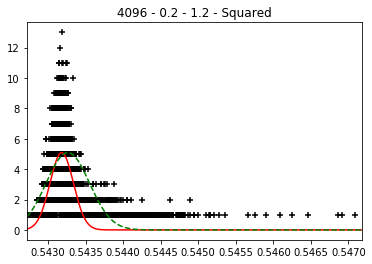

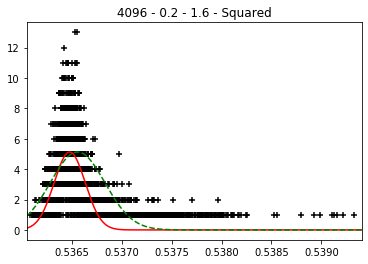

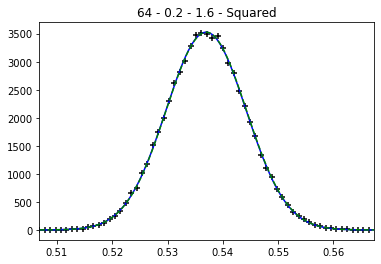

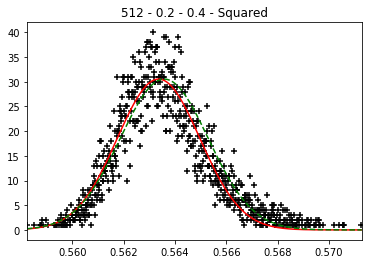

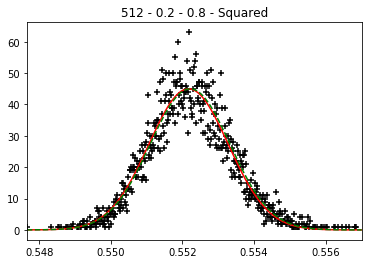

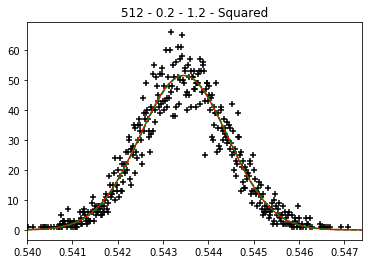

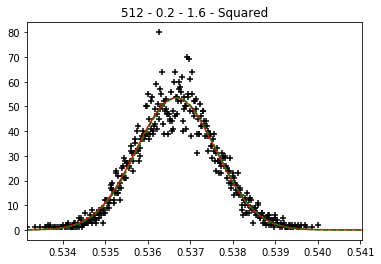

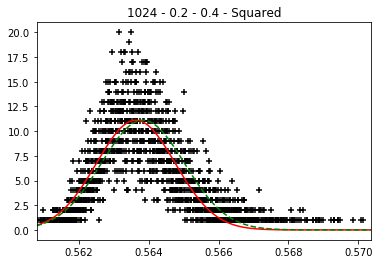

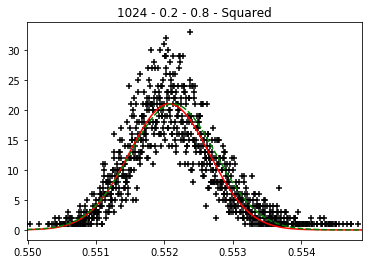

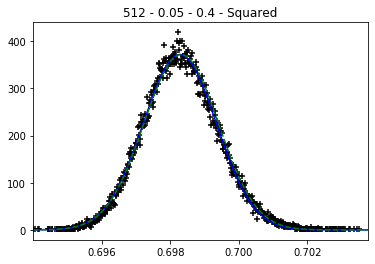

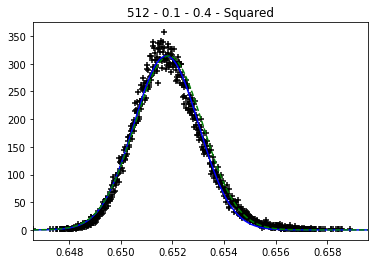

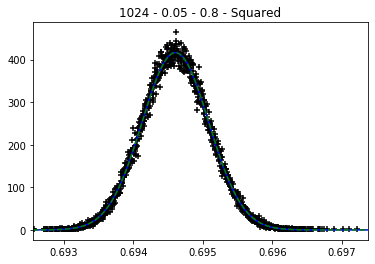

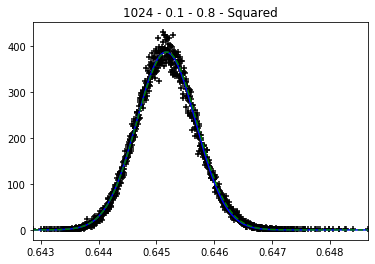

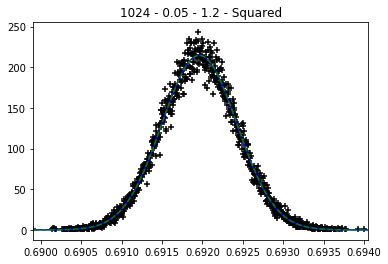

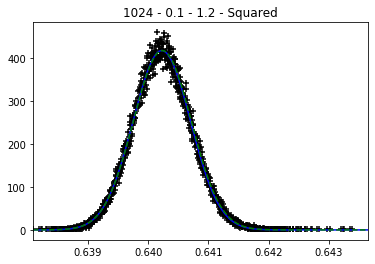

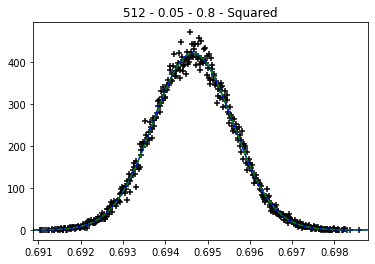

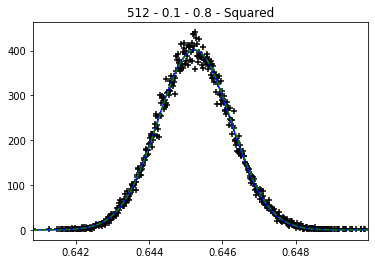

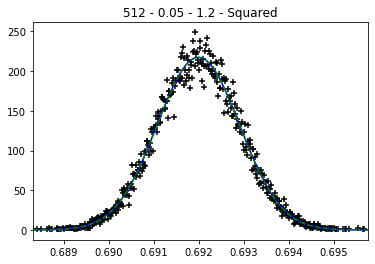

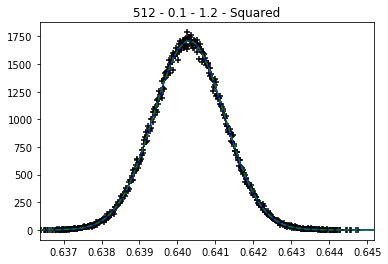

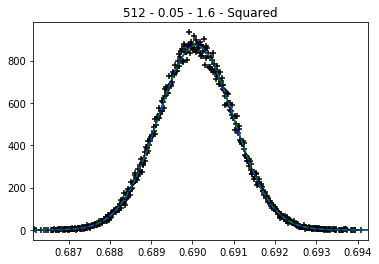

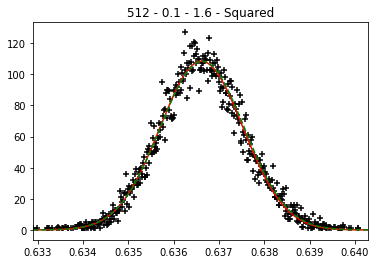

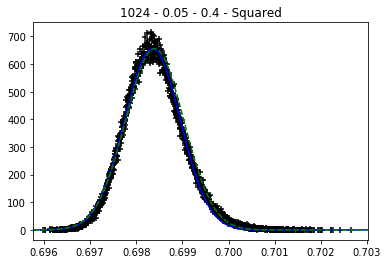

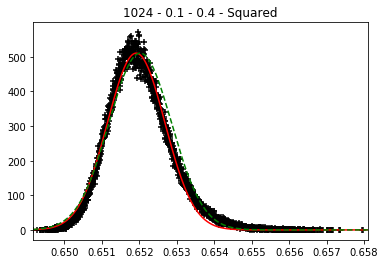

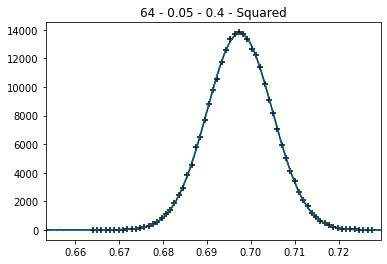

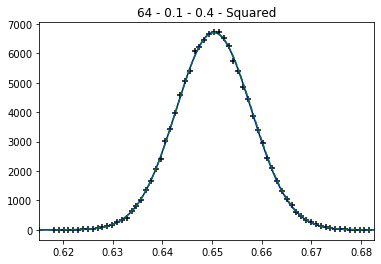

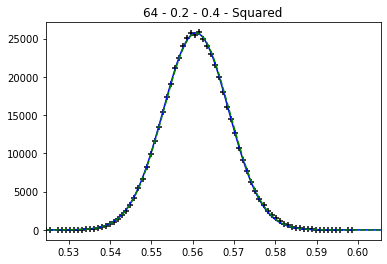

In [138]:
# Load data

def load( filename ):
    text = filename.read_text()
    text = text.replace("nan","0")
    text = text.replace("False", "false" )
    text = text.replace("True", "true" )
    text = text.replace(",]", "]" )
    return json.loads( text )

data = []
computed = []
ppps_count = []

# # Load the big stuff
# p = Path('../CloudVenetoAnalysis/20220331LowResSquaredscan_20220411/')
# dirs = [f for f in p.iterdir() if f.is_dir()]

compute_from_chunks = True
plot_gauss = True

if( plot_gauss ):
    pdf = PdfPages( savepath + "/GaussPlots.pdf" )

for file in glob("../*Analysis/**/details.txt", recursive=True):
    item = {}
    d = Path( os.path.dirname( file ) )
    # Verify that everything exists
    if( not (
        ( d / 'details.txt').exists() and
        ( d / 'deposition.txt').exists() and
        ( d / 'percolation.txt').exists() and
        ( d / 'chunks.txt').exists() ) ):
        continue

    item.update( load( d / 'details.txt'     ) )
    item.update( load( d / 'deposition.txt'  ) )
    item.update( load( d / 'percolation.txt' ) )
    
    # Compute occupation fraction std from chunks
    if( compute_from_chunks ):
        with open( d / "chunks.txt" ) as file:
            lines = file.readlines()
            chunks = json.loads( "[" + lines[-1].replace(",]","]").replace("nan","0") + "]" )[-1]
            item['chunks'] = chunks

            x = np.arange( min( chunks ), max( chunks ) + 1 )
            h, _ = np.histogram( chunks, bins= x - 0.5 )

            x = x / ( item['side']**2 )

            def Gauss(x, A, mu, s):
                y = A*np.exp(-0.5 * ( ( x - mu ) / s )**2 )
                return y
            (A, mu, s), errs = curve_fit( Gauss, x[:-1][h>0], h[h>0], p0 = [ np.sum(h), np.mean(chunks) / ( item['side']**2 ), np.std(chunks) / ( item['side']**2 ) ])

            item['std_from_fit'] = ufloat( s , np.sqrt( errs[2][2] ) )
            item['std_from_np'] = np.std( chunks ) / ( item['side']**2 )
            item['quality_factor'] = np.mean( np.abs( h[h>0] - Gauss( x[:-1][h>0], A, mu, s ) ) ) / A
            item['is_ok'] = ( item['quality_factor'] < 0.03 )

            if( plot_gauss ):
                plt.figure()
                plt.scatter( x[:-1][h>0], h[h>0], marker='+', color='k' )
                plt.plot( x, Gauss( x, A, mu, s ), ('b' if item['is_ok'] else 'r') )
                plt.plot( x, Gauss( x, A, np.mean(chunks) / ( item['side']**2 ), np.std(chunks) / ( item['side']**2 ) ), '--g' )
                plt.title( str( item['side'] ) + " - " + str( item['defects_frac'] ) + " - " + str( item['gamma'] ) + " - " + item['dep_polymers'] )
                plt.xlim( min(x), max(x) )
                pdf.savefig()
                plt.show()

    ppps_count.append( re.match(".+\\\\([^\\\\]+\\\\[^\\\\]+)\\\\.+", str( d )).groups()[0] )

    if( ( not compute_from_chunks ) or item['is_ok']):
        item['thepath'] = ppps_count[-1]
        data.append(item)

if( plot_gauss ):
    pdf.close()

In [139]:
from collections import Counter
ppps = Counter( [ i['thepath'] for i in data ] )
ppps_tot = Counter( ppps_count )
for ppps_k, ppps_v in ppps_tot.items():
    print( f"{ppps_k}:\t {ppps.get(ppps_k)} | {ppps_v}" )

AcerAnalysis\20220331LowResSquaredOrderedscan_20220409_failed:	 8 | 8
AcerAnalysis\20220415LowResSquaredWidescan_20220415:	 7 | 8
AsusAnalysis\20220331LowResDimersscan_20220331:	 7 | 14
AsusAnalysis\20220415LowResSqyaredWidescanBackwardscan_20220418_0:	 16 | 16
CloudVenetoAnalysis\20220331LowResSquaredscan_20220331:	 4 | 6
CloudVenetoAnalysis\20220331LowResSquaredscan_20220410:	 4 | 8
CloudVenetoAnalysis\20220331LowResSquaredscan_20220411:	 7 | 28
CloudVenetoAnalysis\20220415LowResSquaredWidescan_20220415:	 12 | 14
CloudVenetoAnalysis\20220415LowResSquaredWidescan_20220415_bug:	 3 | 3


In [140]:
# useful data
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

polys = np.unique(  [i['dep_polymers'] for i in data] )
sides =  np.unique( [i['side'] for i in data] )
qs =  np.unique( [i['defects_frac'] for i in data] )
gammas =  np.unique( [i['gamma'] for i in data] )
cleaned_data = {}

print( len( data ) )

for p in polys:
    cleaned_data[p] = {}
    for q in qs:
        cleaned_data[p][q] = {}
        for g in gammas:
            cleaned_data[p][q][g] = {}
            for s in sides:
                istance = [ i for i in data if i['dep_polymers'] == p and i['side'] == s and i['defects_frac'] == q and i['gamma'] == g]
                sizes = np.array( [ i['runned_replicas'] for i in istance ] )
                if( len( istance ) > 0 ):
                    cleaned_data[p][q][g][s] = istance[ np.where( sizes == np.amax( sizes ) )[0][-1] ]

                print( p, '\t', '\t', q, '\t', g, '\t', s, '\t',
                    len( istance ), '\t(' , sizes ,')', id
                )


68
Dimers 	 	 0.05 	 0.4 	 64 	 0 	( [] ) <built-in function id>
Dimers 	 	 0.05 	 0.4 	 128 	 1 	( [65536] ) <built-in function id>
Dimers 	 	 0.05 	 0.4 	 256 	 1 	( [65536] ) <built-in function id>
Dimers 	 	 0.05 	 0.4 	 512 	 0 	( [] ) <built-in function id>
Dimers 	 	 0.05 	 0.4 	 1024 	 0 	( [] ) <built-in function id>
Dimers 	 	 0.05 	 0.8 	 64 	 0 	( [] ) <built-in function id>
Dimers 	 	 0.05 	 0.8 	 128 	 1 	( [131072] ) <built-in function id>
Dimers 	 	 0.05 	 0.8 	 256 	 1 	( [131072] ) <built-in function id>
Dimers 	 	 0.05 	 0.8 	 512 	 1 	( [262144] ) <built-in function id>
Dimers 	 	 0.05 	 0.8 	 1024 	 0 	( [] ) <built-in function id>
Dimers 	 	 0.05 	 1.2 	 64 	 0 	( [] ) <built-in function id>
Dimers 	 	 0.05 	 1.2 	 128 	 1 	( [131072] ) <built-in function id>
Dimers 	 	 0.05 	 1.2 	 256 	 1 	( [262144] ) <built-in function id>
Dimers 	 	 0.05 	 1.2 	 512 	 1 	( [65536] ) <built-in function id>
Dimers 	 	 0.05 	 1.2 	 1024 	 0 	( [] ) <built-in function id>
Dimers 

### Delta

$ \Delta \coloneqq \sqrt{ <{ p_j^2 }> - <{ p_j }^2> } $

No handles with labels found to put in legend.
No handles with labels found to put in legend.


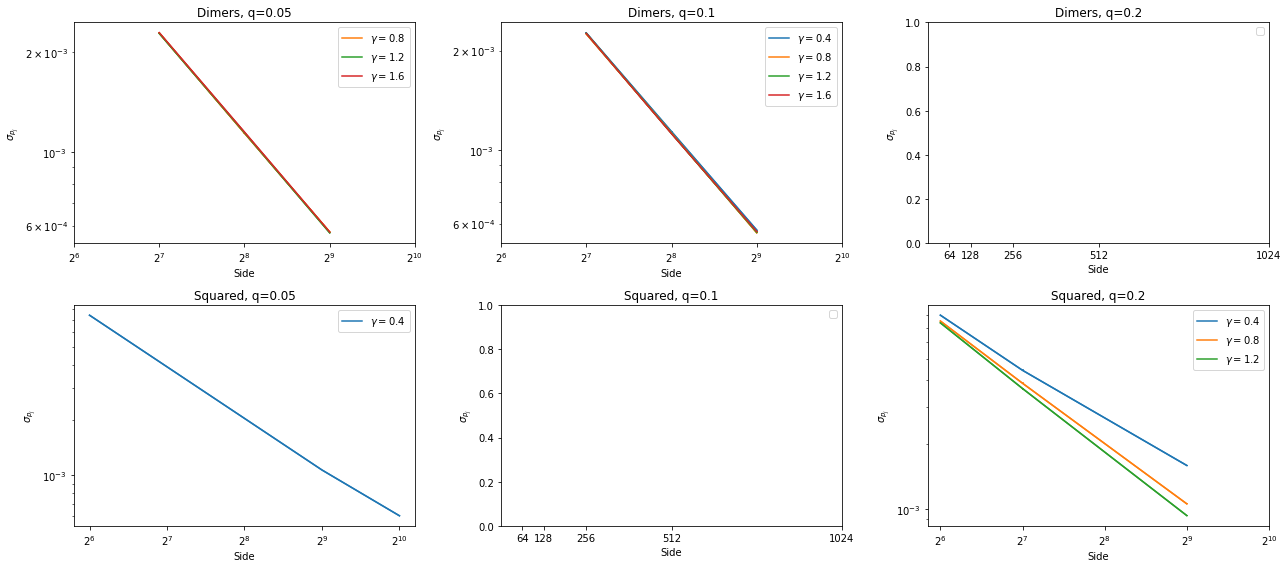

No handles with labels found to put in legend.
No handles with labels found to put in legend.


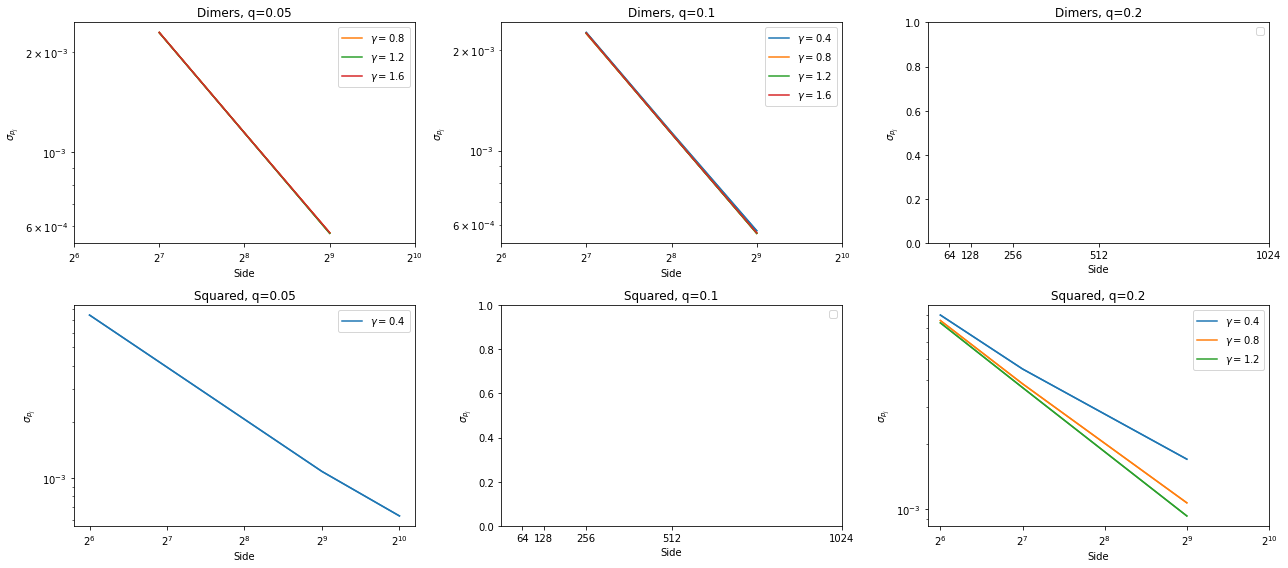

In [147]:
# Jamming density standard deviation as function of L for different values of gamma in different q and different shapes

for method in ['_fit', '_np']:

    fig = plot_init( len( cleaned_data ), np.max( [ len( c ) for c in cleaned_data.values() ] ), False )

    for i_p, (p, cd_p) in enumerate( cleaned_data.items() ):
        for i_q, (q, cd_p_q) in enumerate( cd_p.items() ):
            plot_goto( i_p, i_q )

            for i_g, (g, cd_p_q_g) in enumerate( cd_p_q.items() ):
                x = [ d['side'] for d in cd_p_q_g.values() ]
                y = [ d['std_from' + method ] for d in cd_p_q_g.values() ]
                if( len( x ) < 3 ):
                    continue

                yd= unp.nominal_values( y )
                ye= unp.std_devs( y )

                plt.loglog( x, yd, color=color_list[ i_g ], label= r'$\gamma=$' + str(g), basex = 2, basey = 10 )
                plt.errorbar( x, yd, ye, color=color_list[ i_g ])

                

            plt.title( p + ", q=" + str(q) )
            plt.legend()
            plt.xlabel(r'Side')
            plt.ylabel(r'$\sigma_{p_j}$')
            plt.xticks( sides )

    plt.tight_layout()

    plt.savefig( savepath + "/Delta" + method + ".pdf")
    plt.show()

Assume $\Delta(L) = AL^{-1/\nu} + B $

No handles with labels found to put in legend.
No handles with labels found to put in legend.


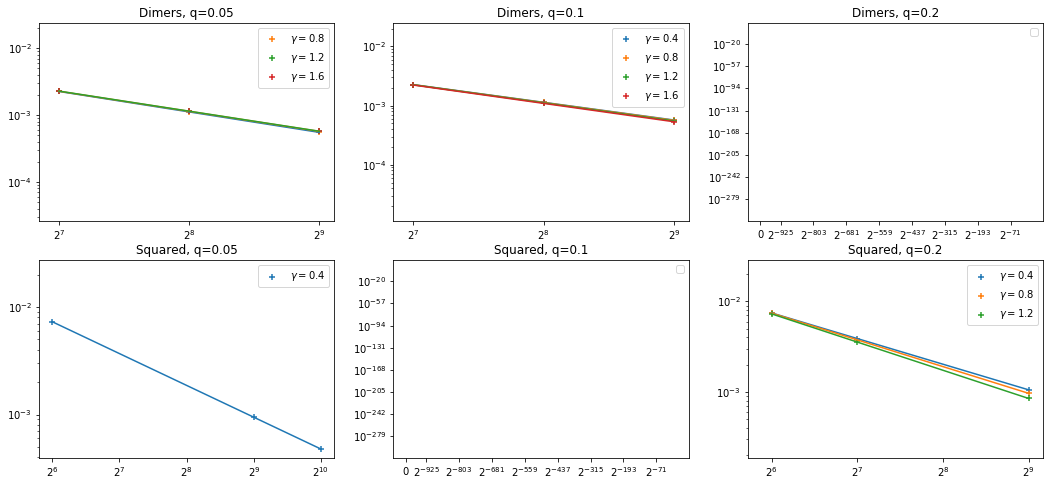

No handles with labels found to put in legend.
No handles with labels found to put in legend.


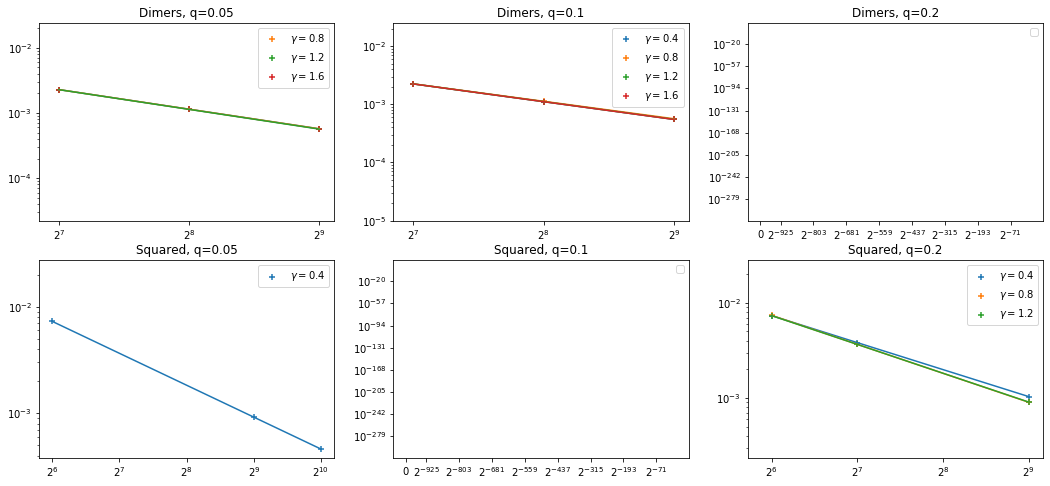

In [148]:
# Fits

fit_results = {}

for method in ['_fit', '_np']:
    fit_results[method] = []

    fig = plot_init( len( cleaned_data ), np.max( [ len( c ) for c in cleaned_data.values() ] ), False )

    ylims_1 = [ 0, 1 ]
    ylims_2 = [ 0, 1 ]

    for i_p, (p, cd_p) in enumerate( cleaned_data.items() ):
        for i_q, (q, cd_p_q) in enumerate( cd_p.items() ):
            plot_goto( i_p, i_q )

            for i_g, (g, cd_p_q_g) in enumerate( cd_p_q.items() ):
                x = np.array( [ d['side'] for d in cd_p_q_g.values() ] )
                uy= np.array( [ d['std_from' + method] for d in cd_p_q_g.values() ] )
                y = unp.nominal_values( uy )
                if( len( x ) < 3 ):
                    continue
                
                sort_idx = np.argsort( x )
                x = x[sort_idx]
                y = y[sort_idx]
                lx= np.log2( x )

                ### Initial values
                [menounosunu, log2A], covmat = polyfit( lx, np.log2(y), 1, cov = True )
                B = 0

                # Direct fit
                def f( args ):
                    (menounosunu, log2A, B) = args
                    return np.log2( y - B ) - log2A - menounosunu * np.log2( x )
                temp = least_squares( f, [menounosunu, log2A, B], bounds=( [-np.inf, -np.inf, 0], [0, np.inf, min(y)] ) )
                ( menounosunu, log2A, B ) = temp.x
                cov = np.array( [ [ 0, 0, 0], [ 0, 0, 0], [ 0, 0, 0]] )
                errmenounosonu = np.sqrt( cov[0,0] )
                errA = np.sqrt( cov[1,1] ) * ( 2 ** log2A )
                errB = np.sqrt( cov[2,2] )

                fit_results[method].append({
                    'gamma': g, 'q': q, 'p': p,
                    'A': ( 2 ** log2A ), 'unosunu': -menounosunu, 'nu': -1/menounosunu, 'B': B,
                    'errA': errA, 'errunosunu': errmenounosonu, 'errnu': errmenounosonu / menounosunu**2, 'errB': errB
                })
                
                plt.scatter( x, y - B, color=color_list[ i_g ], label= r'$\gamma=$' + str( g ), marker='+' )
                plt.plot( x, ( 2 ** log2A ) * ( x ** menounosunu ) )

            plt.xscale( 'log', basex = 2 )
            plt.yscale( 'log', basey = 10 )

            plt.title( p + ", q=" + str(q) )
            plt.legend()

    plt.savefig( 'CriticalExpoF' )
    plt.savefig( "/DeltaFit" + method + ".pdf")

# plt.tight_layout()
    plt.show()

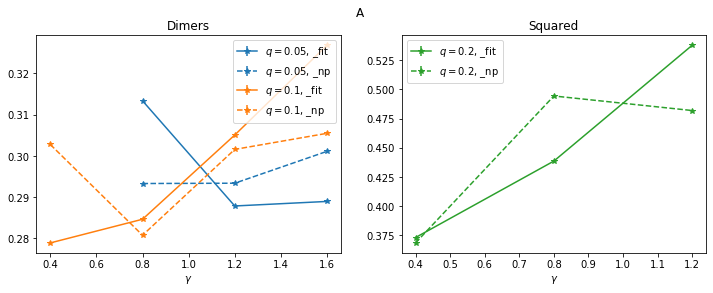

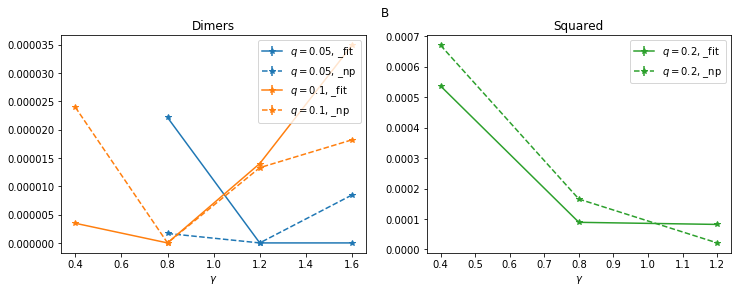

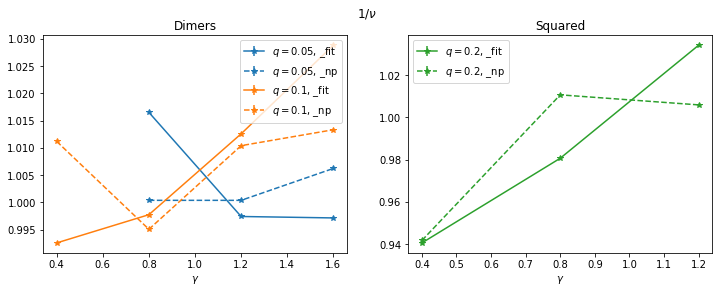

In [153]:
pdf = PdfPages( savepath + "/DeltaFitPars.pdf" )

def plot_quantity( key, title ):
    
    plot_init( 1, len( polys ), False )

    for i_p, (p, cd_p) in enumerate( cleaned_data.items() ):
        plot_next()

        for i_q, (q, cd_p_q) in enumerate( cd_p.items() ):
            for ( method, linestyle ) in [ ('_fit', '-' ), ('_np', '--' ) ]:
                x = np.array([ v['gamma']   for v in fit_results[method] if v['p'] == p and  v['q'] == q ])
                y = np.array([ v[ key ] for v in fit_results[method] if v['p'] == p and  v['q'] == q ])
                erry = np.array([ v['err' + key] for v in fit_results[method] if v['p'] == p and  v['q'] == q ])

                if( len( x ) < 2 ):
                    continue

                sort_idx = np.argsort( x )
                plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], marker='*', linestyle=linestyle, label= r'$q=$' + str(q) + ", " + method )
    
        plt.title( p )
        plt.legend()
        plt.xlabel( r"$\gamma$" )

    plt.suptitle( title )

    pdf.savefig()
    plt.show()

plot_quantity( 'A', 'A' )
plot_quantity( 'B', 'B' )
plot_quantity( 'unosunu', r"$1/\nu$" )

pdf.close()

##  Percolation studies

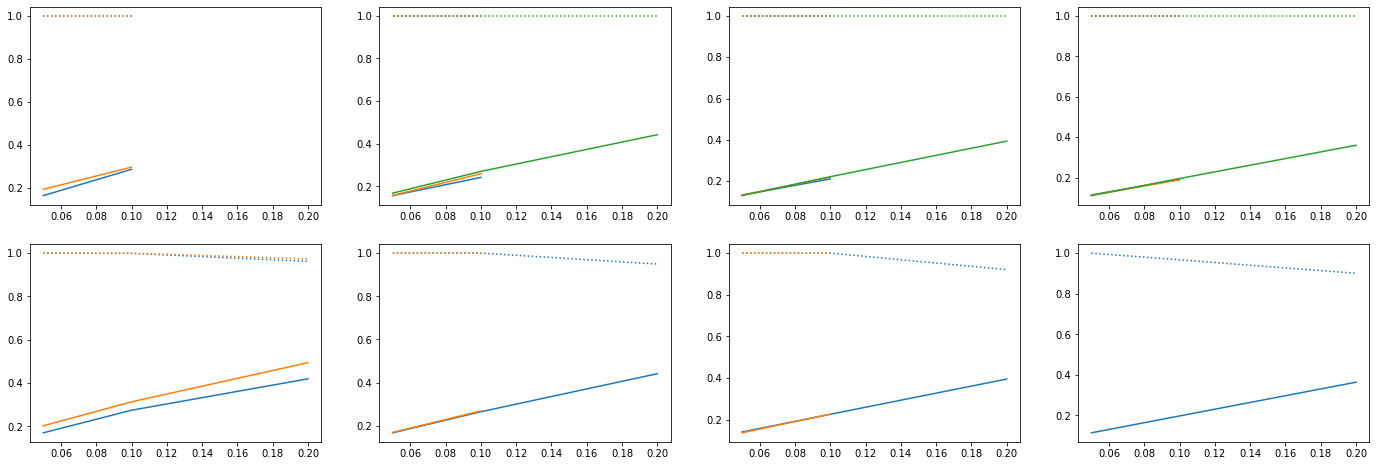

In [109]:
# Percolation probability as function of q for different values of L in different gamma and different shapes

data_reordered = {}

def nested_dict( dict, item, keys ):
    d = dict
    for k in keys[:-1]:
        if( k not in d ):
            d[k] = {}
        d = d[k]
    d[ keys[-1] ] = item

for i_p, (p, cd_p) in enumerate( cleaned_data.items() ):
    for i_q, (q, cd_p_q) in enumerate( cd_p.items() ):
        for i_g, (g, cd_p_q_g) in enumerate( cd_p_q.items() ):
            for d in cd_p_q_g.values():
                nested_dict( data_reordered, d, [p, g, d['side'], q] )

fig = plot_init( len( data_reordered ), np.max( [ len( c ) for c in data_reordered.values() ] ), False )

for i_p, (p, cd_p) in enumerate( data_reordered.items() ):
    for i_g, (g, cd_p_g) in enumerate( cd_p.items() ):
        plot_goto( i_p, i_g )
        for i_s, (s, cd_p_g_s) in enumerate( cd_p_g.items() ):
            x = np.array( list( cd_p_g_s.keys() ) )
            y1= np.array( [ d['defperc_avg'] for d in cd_p_g_s.values() ] )
            y2= np.array( [ d['atmperc_avg'] for d in cd_p_g_s.values() ] )

            sort_idx = np.argsort( x )
            plt.plot( x[sort_idx], y1[sort_idx], '-', color=color_list[ i_s ], label= f"Side: {s}" )
            plt.plot( x[sort_idx], y2[sort_idx], ':', color=color_list[ i_s ] )